# Data Scientist Professional Practical Exam Submission

**Use this template to write up your summary for submission. Code in Python or R needs to be included.**


## 📝 Task List

Your written report should include both code, output and written text summaries of the following:
- Data Validation:   
  - Describe validation and cleaning steps for every column in the data 
- Exploratory Analysis:  
  - Include two different graphics showing single variables only to demonstrate the characteristics of data  
  - Include at least one graphic showing two or more variables to represent the relationship between features
  - Describe your findings
- Model Development
  - Include your reasons for selecting the models you use as well as a statement of the problem type
  - Code to fit the baseline and comparison models
- Model Evaluation
  - Describe the performance of the two models based on an appropriate metric
- Business Metrics
  - Define a way to compare your model performance to the business
  - Describe how your models perform using this approach
- Final summary including recommendations that the business should undertake

*Start writing report here..*

## Data Validation

The dataset contains **947 rows and 8 columns** before cleaning and validation. I have validated all the columns against the criteria in the dataset table:

* *recipe*: numeric variable, 947 unique values, no missing values, used only for numbering recipes and does not have any predictive value, it was discarded.
* *high_traffic*: 373 null values, filled the missing rows with the value *Not High* (This is a temporary value that will be encoded later), variable type changed from object to category. This is the target variable we are trying to predict. After cleaning, there are 574 *High* and 373 *Not High* values in this column.
* *category*: no missing values, 11 categories, which is one category more than described, *Chicken Breast* was replaced by *Chicken*, the variable type changed from object to category.
* *calories*: numeric variable, values from 0.14 to 3633.16, 52 null values, imputed the missing values with medians for each recipe category.
* *carbohydrate*: numeric variable, values form 0.03 to 530.42, 52 null values, imputed the missing values with medians for each recipe category.
* *sugar*: numeric variable, values from 0.01 to 148.75, 52 null values, imputed the missing values with medians for each recipe category.
* *protein*: numeric variable, values from 0 to 363.36, 52 null values, imputed the missing values with medians for each recipe category.
* *servings*: 6 categories before cleaning, two rows with *4 as a snack* value, replaced by *4*, one row with *6 as a snack* value, replaced by *6*, 4 categories after cleaning: *1*, *2*, *4*, *6*.

After validation the dataset contains **947 rows and 7 columns**.

In [101]:
# Necessary imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score

In [102]:
#Import the dataset and inspect first few rows
df = pd.read_csv('recipe_site_traffic_2212.csv')
df.head()

,recipe,calories,carbohydrate,sugar,protein,category,servings,high_traffic
0,1,NaN,NaN,NaN,NaN,Pork,6,High
1,2,35.48,38.56,0.66,0.92,Potato,4,High
2,3,914.28,42.68,3.09,2.88,Breakfast,1,NaN
3,4,97.03,30.56,38.63,0.02,Beverages,4,High
4,5,27.05,1.85,0.80,0.53,Beverages,4,NaN


In [103]:
# Explore the dataset, check the number of rows, columns and data types
df.shape

(947, 8)

In [104]:
# Basic statistics
df.describe(include = 'all') # All values in calories, carbohydrate, sugar and protein columns are non-negative and have reasonable bounds

,recipe,calories,carbohydrate,sugar,protein,category,servings,high_traffic
count,947.000000,895.000000,895.000000,895.000000,895.000000,947,947,574
unique,NaN,NaN,NaN,NaN,NaN,11,6,1
top,NaN,NaN,NaN,NaN,NaN,Breakfast,4,High
freq,NaN,NaN,NaN,NaN,NaN,106,389,574
mean,474.000000,435.939196,35.069676,9.046547,24.149296,NaN,NaN,NaN
std,273.519652,453.020997,43.949032,14.679176,36.369739,NaN,NaN,NaN
min,1.000000,0.140000,0.030000,0.010000,0.000000,NaN,NaN,NaN
25%,237.500000,110.430000,8.375000,1.690000,3.195000,NaN,NaN,NaN
50%,474.000000,288.550000,21.480000,4.550000,10.800000,NaN,NaN,NaN
75%,710.500000,597.650000,44.965000,9.800000,30.200000,NaN,NaN,NaN


In [105]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 947 entries, 0 to 946
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   recipe        947 non-null    int64  
 1   calories      895 non-null    float64
 2   carbohydrate  895 non-null    float64
 3   sugar         895 non-null    float64
 4   protein       895 non-null    float64
 5   category      947 non-null    object 
 6   servings      947 non-null    object 
 7   high_traffic  574 non-null    object 
dtypes: float64(4), int64(1), object(3)
memory usage: 59.3+ KB


In [106]:
# Check for duplicated rows
df.duplicated().sum() # = 0 means there aren't any duplicated rows

0

In [107]:
# Check for missing values
df.isna().sum()

recipe            0
calories         52
carbohydrate     52
sugar            52
protein          52
category          0
servings          0
high_traffic    373
dtype: int64

In [108]:
# Explore high_traffic colums (373 missing values)
df['high_traffic'].value_counts(dropna = False)

High    574
NaN     373
Name: high_traffic, dtype: int64

In [109]:
# Need to introduce a new category - Not High - for recipes that were not marked as High since null is not appropriate for further analysis (this variable is going to be encoded into numeric later).
df['high_traffic'].fillna("Not High", inplace = True)

In [110]:
# See if data imputation successful
df['high_traffic'].value_counts(dropna = False)

High        574
Not High    373
Name: high_traffic, dtype: int64

In [111]:
# Explore category column
df['category'].value_counts()

Breakfast         106
Chicken Breast     98
Beverages          92
Lunch/Snacks       89
Potato             88
Pork               84
Vegetable          83
Dessert            83
Meat               79
Chicken            74
One Dish Meal      71
Name: category, dtype: int64

In [112]:
# Chicken Breast will be incorporated into Chicken category
df['category'] = df['category'].str.replace('Chicken Breast', 'Chicken')

# Check if succesful
df['category'].value_counts()

Chicken          172
Breakfast        106
Beverages         92
Lunch/Snacks      89
Potato            88
Pork              84
Vegetable         83
Dessert           83
Meat              79
One Dish Meal     71
Name: category, dtype: int64

In [113]:
# There are 52 missing values in calories, carbohydrate, sugar and protein columns 

# Check if all missing values in calories, carbohydrate, sugar and protein columns are in the same rows
len(df[df['calories'].isna()]) # = 52 means all missing values are in the same rows


52

In [114]:
# Check the percentage of missing values
df['calories'].isna().sum()/len(df)

0.054910242872228086

In [115]:
# Check the number of recipes of each character in rows with missing values
df[df['calories'].isna()]['high_traffic'].value_counts()

High        39
Not High    13
Name: high_traffic, dtype: int64

In [116]:
# Check the distribution of recipe type across different categories in rows with missing values
df[df['calories'].isna()].groupby(by = ['category', 'high_traffic']).size()

category       high_traffic
Chicken        High             4
               Not High         5
Dessert        High             5
               Not High         1
Lunch/Snacks   High             5
               Not High         2
Meat           High             3
               Not High         2
One Dish Meal  High             1
               Not High         3
Pork           High            11
Potato         High             5
Vegetable      High             5
dtype: int64

In [117]:
# 75% of rows with missing values are labeld as High. It may be better to do imputation instead of dropping them

# Make copy of df
df_imputed = df.copy()

# Impute missing rows with median for each recipe category
cols_to_impute = ['calories', 'carbohydrate', 'sugar', 'protein']

for col in cols_to_impute:
    map_dict = df_imputed.groupby(by = 'category')[col].median().to_dict()
    df_imputed[col] = df_imputed[col].fillna(df_imputed['category'].map(map_dict))

# Check for missing values
df_imputed.isna().sum()

recipe          0
calories        0
carbohydrate    0
sugar           0
protein         0
category        0
servings        0
high_traffic    0
dtype: int64

In [118]:
# Check medians of different categories
df.groupby(by = 'category')['protein'].median()

category
Beverages         0.410
Breakfast        11.685
Chicken          33.170
Dessert           4.810
Lunch/Snacks     12.965
Meat             28.530
One Dish Meal    28.480
Pork             29.820
Potato            5.900
Vegetable         4.835
Name: protein, dtype: float64

In [119]:
# Check whether right values were imputed
df_imputed[df['protein'].isna()].head()

,recipe,calories,carbohydrate,sugar,protein,category,servings,high_traffic
0,1,399.26,19.560,5.230,29.82,Pork,6,High
23,24,460.87,19.115,3.385,28.53,Meat,2,Not High
48,49,379.16,15.490,3.500,33.17,Chicken,4,Not High
82,83,460.87,19.115,3.385,28.53,Meat,4,High
89,90,399.26,19.560,5.230,29.82,Pork,6,High


In [120]:
# Explore servings column 
df['servings'].value_counts() 

4               389
6               197
2               183
1               175
4 as a snack      2
6 as a snack      1
Name: servings, dtype: int64

In [121]:
# Since there are only two recipes labeled '4 as a snack' I decided to incorporate them into '4' category. Similarly the only '6 as a snack' recipe was incorporated into '6' category.
df_imputed['servings'] = df_imputed['servings'].str.replace('4 as a snack', '4')
df_imputed['servings'] = df_imputed['servings'].str.replace('6 as a snack', '6')

df_imputed['servings'].value_counts() # Check if cleaning succesful

4    391
6    198
2    183
1    175
Name: servings, dtype: int64

In [122]:
# Type conversions. All columns of object type cast to category type
df_imputed['category'] = df_imputed['category'].astype('category')
df_imputed['high_traffic'] = df_imputed['high_traffic'].astype('category')
df_imputed['servings'] = df_imputed['servings'].astype('category')

df_imputed.dtypes # check if type conversion succesfull

recipe             int64
calories         float64
carbohydrate     float64
sugar            float64
protein          float64
category        category
servings        category
high_traffic    category
dtype: object

In [123]:
# Drop recipe column, as it is used to number recipes and has no explanatory power
df_imputed.drop('recipe', inplace = True, axis='columns')

df_imputed.head() # check if recipe column was removed

,calories,carbohydrate,sugar,protein,category,servings,high_traffic
0,399.26,19.56,5.23,29.82,Pork,6,High
1,35.48,38.56,0.66,0.92,Potato,4,High
2,914.28,42.68,3.09,2.88,Breakfast,1,Not High
3,97.03,30.56,38.63,0.02,Beverages,4,High
4,27.05,1.85,0.80,0.53,Beverages,4,Not High


In [124]:
# Summary of the dataset with missing rows imputed
df_imputed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 947 entries, 0 to 946
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   calories      947 non-null    float64 
 1   carbohydrate  947 non-null    float64 
 2   sugar         947 non-null    float64 
 3   protein       947 non-null    float64 
 4   category      947 non-null    category
 5   servings      947 non-null    category
 6   high_traffic  947 non-null    category
dtypes: category(3), float64(4)
memory usage: 33.2 KB


## Exploratory Analysis

## Target variable - high_traffic

Since we need to predict the traffic type of the recipe (*High* vs *Not High*), the *high_traffic* variable would be our target variable. There is an imbalance in the dataset, with a higher proportion of recipes that generate high traffic on the website (61%) compared to those that do not (39%). This lack of balance will be taken into account during the further analysis and the division of the dataset into training and testing sets.

In [125]:
# Set colorblind palette in seaborn
sns.set_palette('colorblind')

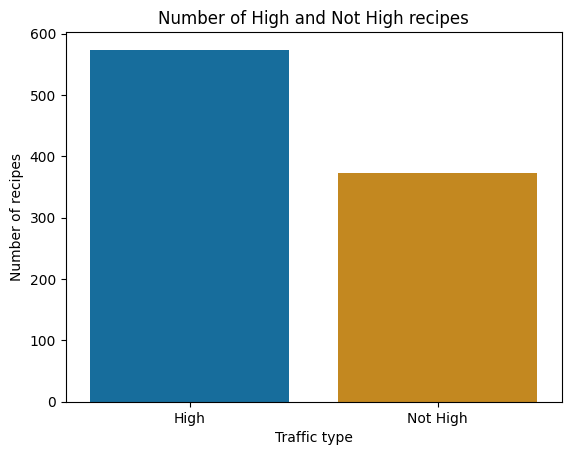

In [126]:
# Create a single variable plot, countplot of category variable
fig, ax = plt.subplots()
# fig.set_size_inches(10, 6)
sns.countplot(data = df_imputed, x = 'high_traffic')
# plt.xticks(rotation=45)
plt.title("Number of High and Not High recipes")
plt.xlabel('Traffic type')
plt.ylabel('Number of recipes')
plt.show()

## Numeric variables - calories, carbohydrate, sugar, protein

### Distributions

Distributions of all numeric variables resemble exponential distributions. The vast majority of dishes have low to moderate calorie and macronutrient content. There are few values in each column that could be considered outliers but I decided not to remove them.

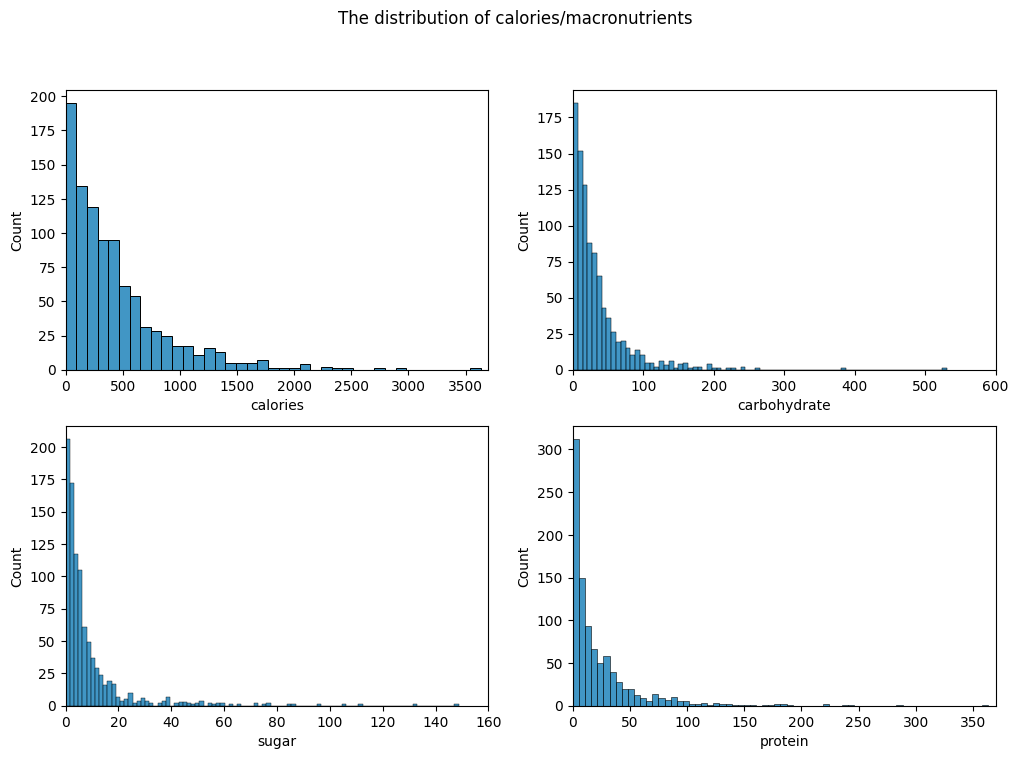

In [127]:
# Create a single variable plot, the distribution of calories
fig, ax = plt.subplots(nrows = 2, ncols = 2)
fig.set_size_inches(12, 8)

sns.histplot(x = 'calories', data = df_imputed, ax  = ax[0][0])
ax[0][0].set_xlim(0, 3700)

sns.histplot(x = 'carbohydrate', data = df_imputed, ax  = ax[0][1])
ax[0][1].set_xlim(0, 600)

sns.histplot(x = 'sugar', data = df_imputed, ax  = ax[1][0])
ax[1][0].set_xlim(0, 160)

sns.histplot(x = 'protein', data = df_imputed, ax  = ax[1][1])
ax[1][1].set_xlim(0, 370)

plt.suptitle('The distribution of calories/macronutrients')
plt.show()

### Relationship between calories/macronutrients and traffic_type (target variable)

For *calories*, *carbohydrate*, and *protein*, the median values for recipes that generate high traffic are slightly higher than for the rest of the recipes. This may suggest that meals with higher protein, carbohydrate, and calorie content are more likely to lead to increased website traffic. However, for sugars, the situation is reversed. The median for recipes that generate high traffic is lower than for the rest of the recipes. This may indicate that recipes with high sugar content are less likely to generate increased website traffic.

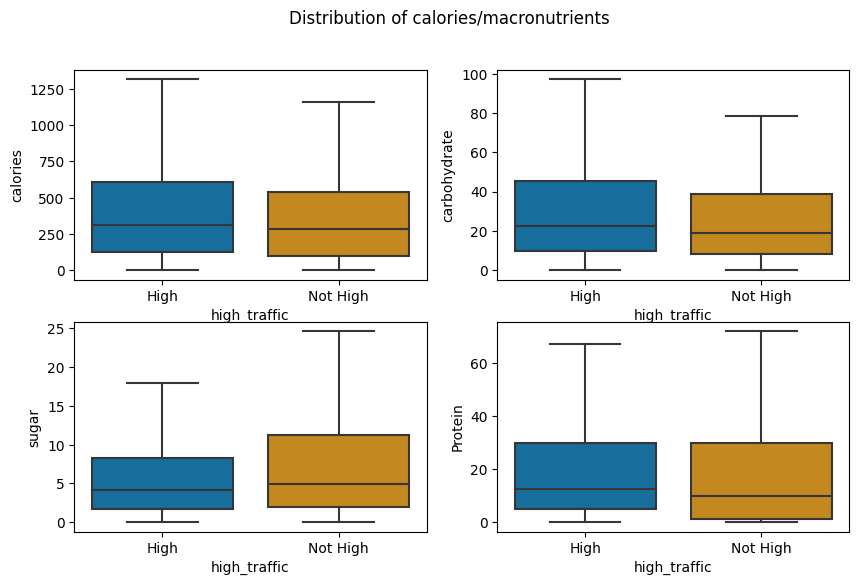

In [128]:
# Create a two variable plot, traffic type vs calories/macronutrients
fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (10,6))
sns.boxplot(x = 'high_traffic', y = 'calories', data = df_imputed, ax = ax[0][0], showfliers = False)
plt.ylabel('Calories')

sns.boxplot(x = 'high_traffic', y = 'carbohydrate', data = df_imputed, ax = ax[0][1], showfliers = False)
plt.ylabel('Carbohydrates')

sns.boxplot(x = 'high_traffic', y = 'sugar', data = df_imputed, ax = ax[1][0], showfliers = False)
plt.ylabel('Sugar')

sns.boxplot(x = 'high_traffic', y = 'protein', data = df_imputed, ax = ax[1][1], showfliers = False)
plt.ylabel('Protein')

fig.suptitle('Distribution of calories/macronutrients')

plt.show()

## Categorical variables - servings, category

### Relationship between servings and traffic_type (target variable)

For each number of servings, there is a prevalence of recipes that generate high website traffic, but the ratio between *High* and *Not High* recipes for each serving size is similar to the overall ratio in the dataset.

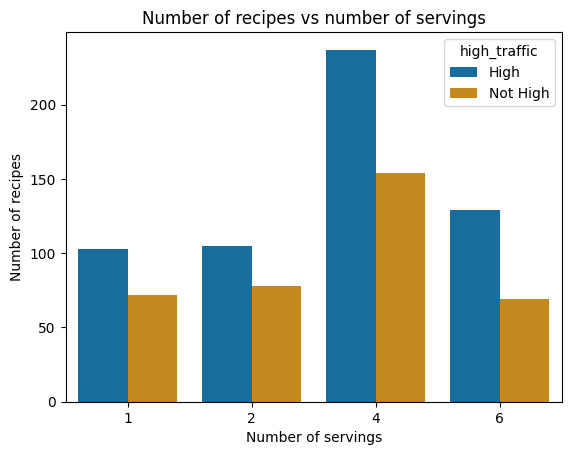

In [129]:
# Create a two variable plot, number of servings with respect to traffic type
fig, ax = plt.subplots()
# fig.set_size_inches(10, 6)

sns.countplot(x = "servings", data = df_imputed, hue = 'high_traffic', ax = ax)
plt.xlabel('Number of servings')
plt.ylabel('Number of recipes')
plt.title("Number of recipes vs number of servings")

plt.show()

### Relationship between meal category and traffic_type (target variable)

The meal category strongly influences whether a recipe generates high website traffic. For the *Beverages* category, it is almost certain that a recipe will not generate high traffic. For the categories *Breakfast* and *Chicken* the majority of recipes do not lead to increased website traffic. In the *Dessert* and *Lunch/Snacks* categories, there is a prevalence of recipes that generate high traffic, but the ratio between *High* and *Not High* recipes in these categories reflects the class imbalance. For the categories *Meat*, *One Dish Meal*, *Pork*, *Potato* and *Vegetable* there is a clear predominance of recipes that generate high website traffic. Almost all recipes in the *Vegetable* category are associated with high website traffic.


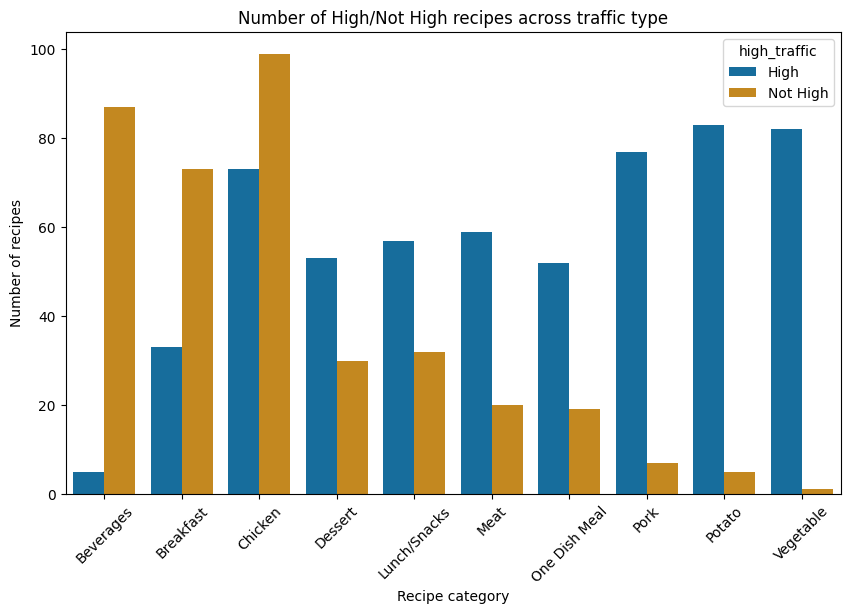

In [130]:
# Create a two variable plot, countplot of category variable with respect to high_traffic variable
fig, ax = plt.subplots()
fig.set_size_inches(10, 6)

sns.countplot(x = "category", data = df_imputed, hue = 'high_traffic', ax = ax)
plt.xticks(rotation=45)
plt.title("Number of High/Not High recipes across traffic type")
plt.xlabel('Recipe category')
plt.ylabel('Number of recipes')

plt.show()

## Model Development

The problem we want to solve is a **binary classification problem**. Specifically, for a given recipe, we want to predict whether publishing it on the website will generate high traffic. **The dependent variable** is *high_traffic* and the **independent variables** are *calories*, *carbohydrate*, *sugar*, *protein*, *category* and *servings*. Since we are dealing with a classification problem, two models were chosen: **Logistic Regression** (simple but powerful and has interpretable regression coefficients) and **Random Forest Classifier** (resistant to outliers).

### Data Preparation

After splitting the data into X and y, all categorical variables were encoded. The *traffic_type* variable was encoded such that a value 1 corresponds to *High* and a value of 0 to *Not High* traffic type recipes.
The dataset was split into training data (80%) and test data (20%) such that the class imbalance in *traffic_type* column is reflected in the split. Additionally all numeric variables were normalized.

In [131]:
# Try to solve binary classification problem (High vs Not High recipes). 
# Independent variables: calories, carbohydrate, sugar, protein, servings, category
X = df_imputed.drop('high_traffic', axis = 'columns')

# Dummy encode X's categorical variables, drop_first = True to not introduce correlations between variables
X = pd.get_dummies(X, drop_first = True)
X.head()

,calories,carbohydrate,sugar,protein,category_Breakfast,category_Chicken,category_Dessert,category_Lunch/Snacks,category_Meat,category_One Dish Meal,category_Pork,category_Potato,category_Vegetable,servings_2,servings_4,servings_6
0,399.26,19.56,5.23,29.82,0,0,0,0,0,0,1,0,0,0,0,1
1,35.48,38.56,0.66,0.92,0,0,0,0,0,0,0,1,0,0,1,0
2,914.28,42.68,3.09,2.88,1,0,0,0,0,0,0,0,0,0,0,0
3,97.03,30.56,38.63,0.02,0,0,0,0,0,0,0,0,0,0,1,0
4,27.05,1.85,0.80,0.53,0,0,0,0,0,0,0,0,0,0,1,0


In [132]:
# Dependent variable: high_traffic (needs to be encoded)
# Encoding High as 1 and Not High as 0
y = df_imputed['high_traffic'].replace({"High" : 1, 'Not High' : 0}).astype('int')
y.head()

0    1
1    1
2    0
3    1
4    0
Name: high_traffic, dtype: int64

In [133]:
# Create train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 87, stratify = y)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(757, 16) (190, 16) (757,) (190,)


In [134]:
# Scale numerical columns
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled[:3] # Check if scaling was succesfull

array([[0.08389809, 0.05730622, 0.20566088, 0.03244716, 0.        ,
        0.        , 0.        , 1.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 1.        ,
        0.        ],
       [0.17778004, 0.05761951, 0.26442114, 0.04604249, 0.        ,
        0.        , 1.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        1.        ],
       [0.21108989, 0.06456413, 0.00376496, 0.08550749, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 1.        , 0.        , 0.        , 1.        ,
        0.        ]])

In [135]:
# Models selected: LogisticRegression, RandomForestClassifier
lr = LogisticRegression(random_state = 87)
rf = RandomForestClassifier(random_state = 87)

# Fit each model to the train data
lr.fit(X_train_scaled, y_train)
rf.fit(X_train_scaled, y_train)

RandomForestClassifier(random_state=87)

## Model Evaluation

To compare both models, we need to consider a metric that is most appropriate for the problem at hand. To do so, we need to answer the question of whether false positives (classifying *Not High* recipe as *High*) or false negatives (classifying *High* recipe as *Not High*) would be more costly for the company. If a recipe is falsely classified as *High*, the company will not notice increased website traffic, resulting in financial loss. Therefore, **precision** was chosen as the most suitable metric to evaluate the model's performance as it quantifies the number of positive class predictions that actually belong to the positive class.

### Cross-validation of Logistic Regression and Random Forrest Classifier

To better compare the models' the performance, a 10-fold cross-validation on the training set was performed. A considerable variation in precision was observed, ranging from 69% to 87% for both models. The variability is due to randomness in splitting the data into training and testing sets. The **average results** are: 80% for Logistic Regression and 76% for Random Forest Classifier. Therefore, the **Logistic Regression model** performs better. However, it should be noted that the Random Forest Classifier was trained with default values for hyperparameters. It is possible that a different set of hyperparameters could yield better results for this model. However, hyperparameter tuning is computationally expensive, so this step was not performed.

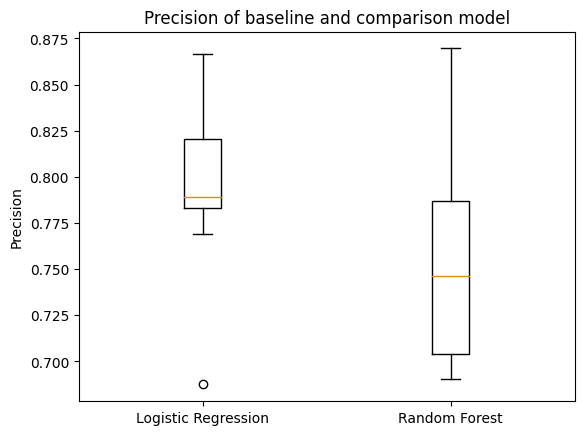

In [136]:
# Evaluate precision of different models
models = {"Logistic Regression": lr, "Random Forest": rf}

results = []

# 10-fold cross validation
for model in models.values():     
    kf = KFold(n_splits=10)     
    cv_results = cross_val_score(model, X_train_scaled, y_train, cv=kf, scoring = 'precision')             
    results.append(cv_results)
    
plt.boxplot(results, labels=models.keys())
plt.ylabel('Precision')
plt.title("Precision of baseline and comparison model")
plt.show()

In [137]:
# Mean, min and max precision of cross-validation for both models
print(f"Mean precision of Logistic Regression Model: {round(results[0].mean(), 2)}")
print(f"Mean precision of Random Forest Model: {round(results[1].mean(), 2)}")

print(f"Min precision of Logistic Regression Model: {round(results[0].min(), 2)}")
print(f"Min precision of Random Forest Model: {round(results[1].min(), 2)}")

print(f"Max precision of Logistic Regression Model: {round(results[0].max(), 2)}")
print(f"Max precision of Random Forest Model: {round(results[1].max(),2)}")

Mean precision of Logistic Regression Model: 0.8
Mean precision of Random Forest Model: 0.76
Min precision of Logistic Regression Model: 0.69
Min precision of Random Forest Model: 0.69
Max precision of Logistic Regression Model: 0.87
Max precision of Random Forest Model: 0.87


### Test set performance

Summary of performance for both models on the test set.

**Logistic Regression Model**:
* For *High* recipes, 93 of them were correctly classified, and 16 were misclassified.
* For *Not High* recipes, 59 were correctly classified, while 22 were misclassified.
**The precision was 85%**.

**Random Forest Model**:
* For *High* recipes, 88 of them were correctly classified, and 17 were misclassified.
* For *Not High* recipes, 58 were correctly classified, while 27 were misclassified.
**The precision was 84%**.

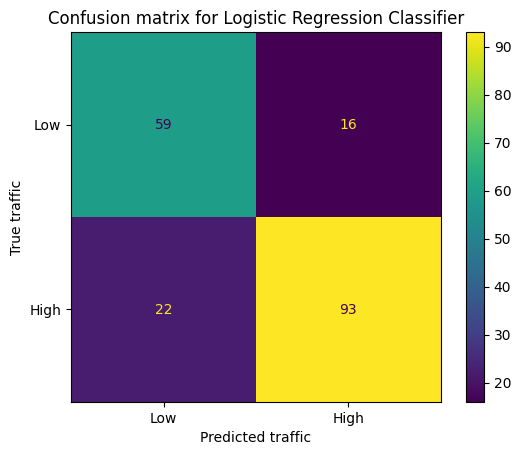

In [138]:
# Make predictions for test data and plot confusion matrix for logistic regression model

# Make predictions
y_pred_lr = lr.predict(X_test_scaled)

# Create and plot confusion matrix
cm_lr = confusion_matrix(y_test, y_pred_lr, labels = lr.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix = cm_lr,display_labels = lr.classes_)
disp.plot()

disp.ax_.set(title = 'Confusion matrix for Logistic Regression Classifier', xlabel = 'Predicted traffic', ylabel = 'True traffic')
disp.ax_.set_xticklabels(['Low', 'High'])
disp.ax_.set_yticklabels(['Low', 'High'])
plt.show()

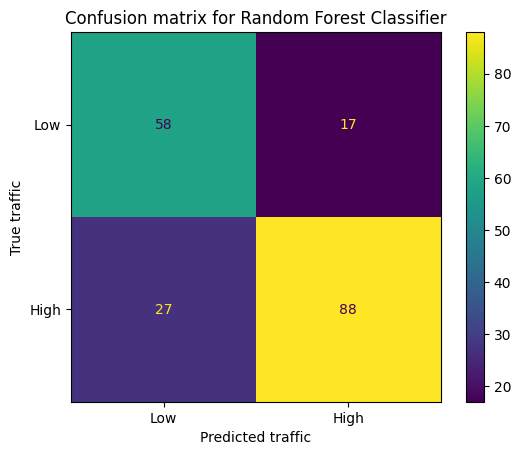

In [139]:
# Make predictions for test data and plot confusion matrix for RandomForestClassifier

# Make predictions
y_pred_rf = rf.predict(X_test_scaled)

# Create and plot confusion matrix
cm_rf = confusion_matrix(y_test, y_pred_rf, labels = rf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix = cm_rf, display_labels = rf.classes_)
disp.plot()
disp.ax_.set(title = 'Confusion matrix for Random Forest Classifier', xlabel = 'Predicted traffic', ylabel = 'True traffic')
disp.ax_.set_xticklabels(['Low', 'High'])
disp.ax_.set_yticklabels(['Low', 'High'])
plt.show()

In [140]:
# Test set performance for logistic regression model
precision_lr = precision_score(y_true = y_test, y_pred = y_pred_lr)

precision_lr

0.8532110091743119

In [141]:
# Test set performance for random forest classifier
precision_rf = precision_score(y_true = y_test, y_pred = y_pred_rf)

precision_rf

0.8380952380952381

### Summary of models' performance

Logistic Regression model performed better than Random Forest Classifier in cross-validation as well as on the test set. Therefore it is recommended for use by Tasty Bites

### Finding the feature importance

Based on the analysis of regression coefficients, the predictive ability of individual features was determined. The results are presented in the graph below.

Three features have a particularly significant impact on the likelihood of classifying a recipe as *High*. These are: *Vegetable*, *Potato*, and *Pork*. The coefficient for the *Sugar* variable has a negative value, indicating that an increase in the amount of sugar in a dish decreases the chance of the recipe to generate high traffic on the website.

In [142]:
# Understand impact of each feature in Logistic Regression Model
# Create data frame with logistic regression coefficients

lr_coefficients = pd.DataFrame(columns = list(X_train.columns), data = lr.coef_)

lr_coefficients

,calories,carbohydrate,sugar,protein,category_Breakfast,category_Chicken,category_Dessert,category_Lunch/Snacks,category_Meat,category_One Dish Meal,category_Pork,category_Potato,category_Vegetable,servings_2,servings_4,servings_6
0,0.216505,0.536028,-1.026147,0.218508,0.18818,0.520629,1.372512,1.157632,1.824595,1.679627,2.714257,3.02284,3.639327,-0.400341,-0.167298,0.121683


In [143]:
# Prepare to plot
lr_coefficients_plot = lr_coefficients.T.squeeze().sort_values(ascending = False)

lr_coefficients_plot.head()

category_Vegetable        3.639327
category_Potato           3.022840
category_Pork             2.714257
category_Meat             1.824595
category_One Dish Meal    1.679627
Name: 0, dtype: float64

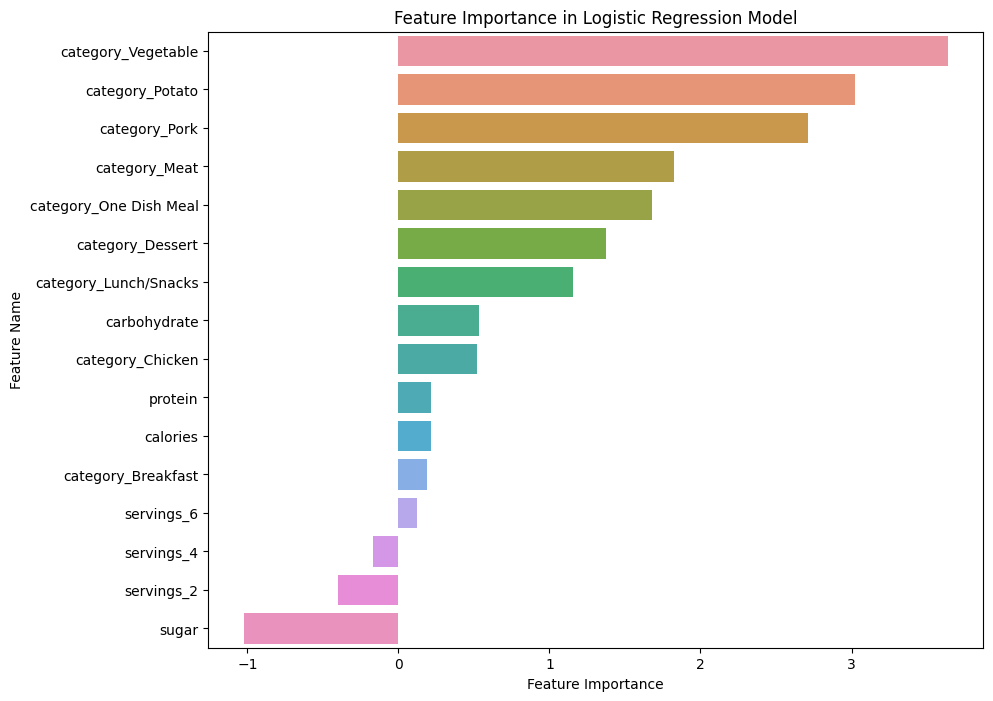

In [144]:
# Plot importance of each feature
plt.figure(figsize=(10,8))

sns.barplot(x = lr_coefficients_plot.values, y = list(lr_coefficients_plot.index))

plt.title('Feature Importance in Logistic Regression Model')
plt.xlabel('Feature Importance')
plt.ylabel('Feature Name')

plt.show()

## Business Metrics

The project has two main business goals:

* Identifying the recipes that generate high traffic on the website.
* Building a model that correctly predicts high traffic recipes 80% of the time.

### Task 1

As for the first problem, three types of recipes consistently generate high traffic on the website: *Vegetable*, *Potato*, and *Pork*. On the other hand, recipes from the *Beverages* and *Breakfast* categories as well as meals with a high sugar content, rarely generate high traffic on the website. This was concluded based on the following graph and analysis of logistic regression coefficients. 

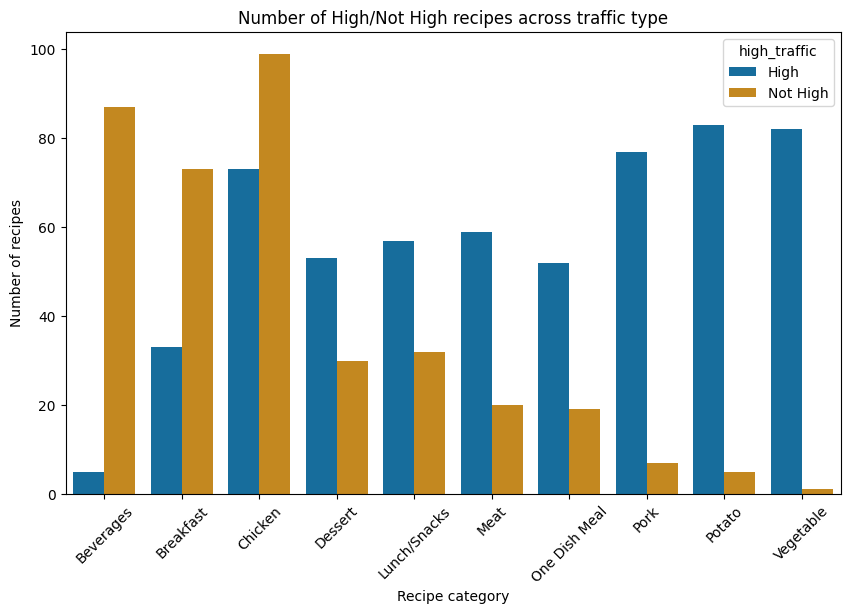

In [145]:
# Create a two variable plot, countplot of category variable with respect to high_traffic variable
fig, ax = plt.subplots()
fig.set_size_inches(10, 6)

sns.countplot(x = "category", data = df_imputed, hue = 'high_traffic', ax = ax)
plt.xticks(rotation=45)
plt.title("Number of High/Not High recipes across traffic type")
plt.xlabel('Recipe category')
plt.ylabel('Number of recipes')

plt.show()

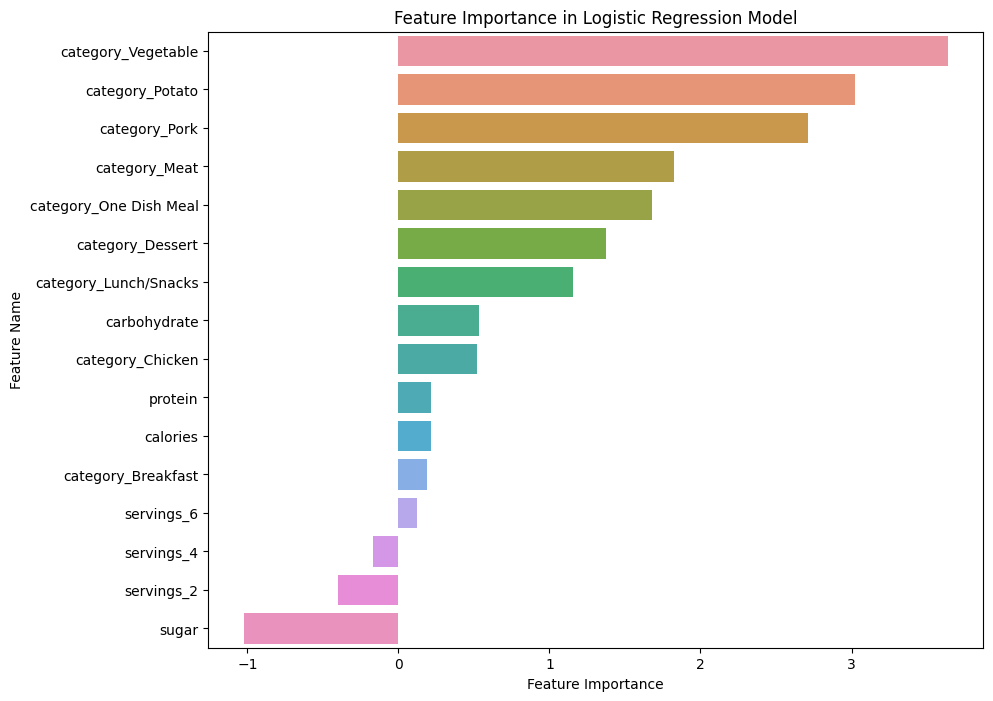

In [146]:
# Plot importance of each feature
plt.figure(figsize=(10,8))

sns.barplot(x = lr_coefficients_plot.values, y = list(lr_coefficients_plot.index))

plt.title('Feature Importance in Logistic Regression Model')
plt.xlabel('Feature Importance')
plt.ylabel('Feature Name')

plt.show()

### Task 2

As for the second problem, the proposed key performance indicator (KPI) is the percentage of *High* type recipes correctly classified by the model, which is the same as the precision metric used to evaluate both models previously. The Logistic Regression Model achieved the desired goal during 10-fold cross-validation (80% on average) and on the test set (85%). The random forest model performed slightly worse during cross-validation (76% on average, below the target level) and on the test set (84%). To compare model performance to the business, the company should record the percentage of days when high traffic on the website was observed (over the next couple weeks).

In [147]:
final_results = pd.DataFrame({'Logistic Regression':[round(results[0].mean(), 2), round(precision_lr,2)], 'Random Forest':[round(results[1].mean(), 2), round(precision_rf, 2)] }, index = ['10-fold cross validation', 'test set'])

# final_results

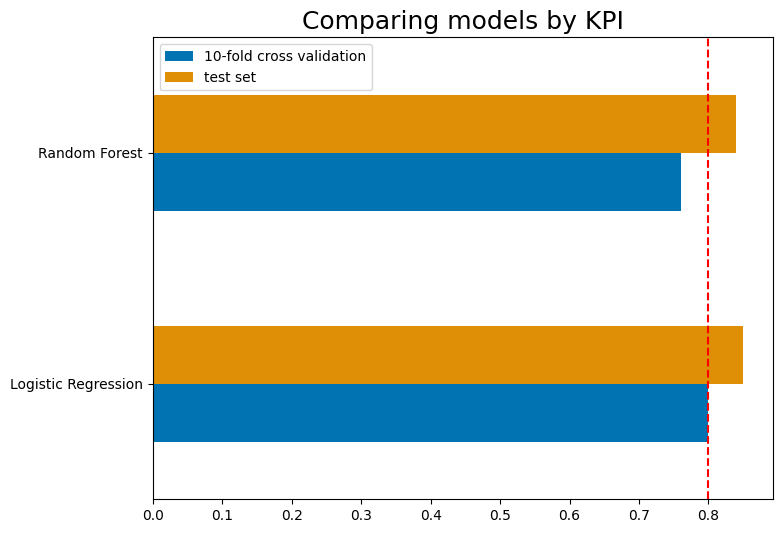

In [148]:
fig, ax = plt.subplots()
fig.set_size_inches([8,6])

final_results.T.plot.barh(ax = ax)
ax.set_title('Comparing models by KPI', fontsize = 18)
ax.axvline(0.8, color = 'r', linestyle = '--')
ax.set_xlabel("% of time high traffic recipes were correctly predicted")

plt.show()

## Recommendations

The Logistic Regression Model predicts high traffic recipes better, so it should be deployed into production. By implementing this model, 80% of the time (on average) high traffic recipes will be predicted.

In addition, to achieve company’s goals I would recommend Tasty Bites to:
* Promote recipes from the categories: *Vegetable*, *Potato*, and *Pork*.
* Do not promote recipes from the *Beverages*/*Breakfast* category or dishes with a high sugar content.

To improve the model, I would recommend the following steps:
* Providing more data, such as the amount of fat in a dish, preparation time, or cooking cost.
* Dividing dishes into more detailed and meaningful categories.

## ✅ When you have finished...
-  Publish your Workspace using the option on the left
-  Check the published version of your report:
	-  Can you see everything you want us to grade?
    -  Are all the graphics visible?
-  Review the grading rubric. Have you included everything that will be graded?
-  Head back to the [Certification Dashboard](https://app.datacamp.com/certification) to submit your practical exam report and record your presentation